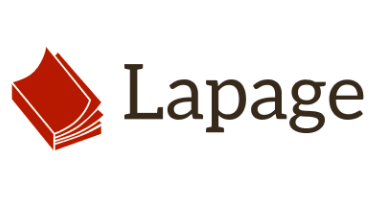

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import pylab as pl
import numpy as np
import plotly.express as px
import statistics
from datetime import datetime, date
from pandas_profiling import ProfileReport
from scipy import stats
from scipy.stats import pareto
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from abc_analysis import abc_analysis, abc_plot
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


# Scénario
Vous êtes consultant Data Analyst chez Lapage, une grande librairie généraliste en ligne très réputée. Vous êtes directement rattaché au service Marketing.
Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. Vous intervenez car l’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc.

# Mission

Une analyse des différents indicateurs de vente, qui a été demandée directement par Antoine. Je t’ai mis en pièce jointe l’e-mail qu’il m’a envoyé résumant ses demandes.
<br>
* Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 
* Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale ?
* Faire un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.
Enfin, j’aimerais avoir quelques informations sur les profils de nos clients, et également la
répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.
Une analyse plus ciblée sur les clients : l’objectif serait cette fois-ci de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques. Pour cela, je t’invite à voir avec Julie, qui te précisera directement ses demandes à ce niveau.


Regarder en particulier :
* Le lien entre le genre d’un client et les catégories des livres achetés
* Le lien entre l’âge des clients et le montant total des achats
* La fréquence d’achat
* La taille du panier moyen et les catégories des livres achetés

**Détail du nettoyage des données : vous présenterez ici l’ensemble des choix et actions que vous avez réalisés afin d’obtenir un jeu de données exploitable.
Restitution de l’analyse : les chiffres clés, KPI, graphiques générés, corrélations calculées, etc.**

* Réaliser une analyse bivariée pour interpréter des données
* Réaliser un test statistique
* Analyser des séries temporelles

# Données
* Compréhension des données
* Utilisation de Panda Profiling
* Rapprochement des tables

## Compréhension des données
Chargement des 3 fichiers csv avec la fonction read_csv de Pandas
<br>Utilisation des fonctions **head(), info(), describe()**

In [2]:
df_customers= pd.read_csv("customers.csv")
df_products= pd.read_csv("products.csv")
df_transactions= pd.read_csv("transactions.csv")

In [3]:
df_customers.head()

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984
3,c_5961,f,1962
4,c_5320,m,1943


In [4]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB


In [5]:
df_customers.describe()

,birth
count,8623.000000
mean,1978.280877
std,16.919535
min,1929.000000
25%,1966.000000
50%,1979.000000
75%,1992.000000
max,2004.000000


In [6]:
df_products.head()

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0


In [7]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB


In [8]:
df_products.describe()

,price,categ
count,3287.000000,3287.000000
mean,21.856641,0.370246
std,29.847908,0.615387
min,-1.000000,0.000000
25%,6.990000,0.000000
50%,13.060000,0.000000
75%,22.990000,1.000000
max,300.000000,2.000000


In [9]:
df_transactions.head()

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714
3,2_209,2021-06-24 04:19:29.835891,s_52962,c_6941
4,0_1509,2023-01-11 08:22:08.194479,s_325227,c_4232


In [10]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679532 entries, 0 to 679531
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
dtypes: object(4)
memory usage: 20.7+ MB


In [11]:
df_transactions.describe()

,id_prod,date,session_id,client_id
count,679532,679532,679532,679532
unique,3267,679371,342316,8602
top,1_369,test_2021-03-01 02:30:02.237413,s_0,c_1609
freq,2252,13,200,25488


## Utilisation de Panda Profiling

In [12]:
profileweb = ProfileReport(df_customers, title="Rapport de la base de donnée customers")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profileweb = ProfileReport(df_products, title="Rapport de la base de donnée products")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
profileweb = ProfileReport(df_transactions, title="Rapport de la base de donnée transactions")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Rapprochement des tables

In [18]:
df_transactions_customers=pd.merge(df_transactions,df_customers, on='client_id')
df_transactions_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679532 entries, 0 to 679531
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id_prod     679532 non-null  object
 1   date        679532 non-null  object
 2   session_id  679532 non-null  object
 3   client_id   679532 non-null  object
 4   sex         679532 non-null  object
 5   birth       679532 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 36.3+ MB


In [19]:
df_transactions_customers_products=pd.merge(df_transactions_customers,df_products, on='id_prod')
df_transactions_customers_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679311 entries, 0 to 679310
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     679311 non-null  object 
 1   date        679311 non-null  object 
 2   session_id  679311 non-null  object 
 3   client_id   679311 non-null  object 
 4   sex         679311 non-null  object 
 5   birth       679311 non-null  int64  
 6   price       679311 non-null  float64
 7   categ       679311 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 46.6+ MB


In [20]:
profileweb = ProfileReport(df_transactions_customers_products, title="Rapport de la base de donnée transactions,customers,products")
profileweb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
df_transactions_customers_products.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986,4.18,0
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986,4.18,0
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968,4.18,0
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968,4.18,0


In [22]:
#duplicate
df_transactions_customers_products.loc[df_transactions_customers_products.duplicated(keep=False),:]

,id_prod,date,session_id,client_id,sex,birth,price,categ
678494,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0,f,2001,-1.0,0
678496,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0,f,2001,-1.0,0
678497,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0,f,2001,-1.0,0
678498,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_0,f,2001,-1.0,0
678499,T_0,test_2021-03-01 02:30:02.237444,s_0,ct_0,f,2001,-1.0,0
...,...,...,...,...,...,...,...,...
678688,T_0,test_2021-03-01 02:30:02.237421,s_0,ct_1,m,2001,-1.0,0
678689,T_0,test_2021-03-01 02:30:02.237420,s_0,ct_1,m,2001,-1.0,0
678690,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1,m,2001,-1.0,0
678692,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1,m,2001,-1.0,0


In [23]:
#Nettoyage des 183 rows dupliquées
df_transactions_customers_products_duplicates=df_transactions_customers_products.drop_duplicates()

#Definir dataframe prix == -1.0 (74rows)
df_prix_inferieure_0=df_transactions_customers_products_duplicates[df_transactions_customers_products_duplicates['price']< 0]

#Definir dataframe prod test (74rows)
df_prod_test=df_transactions_customers_products_duplicates[df_transactions_customers_products_duplicates['id_prod']== 'T_0']

In [24]:
#verifier la similutide des deux dataframes id prod = test et prix =-1
df_prix_inferieure_0.equals(df_prod_test)

True

In [25]:
#Filtre et remplace les valeurs test par Nan
df_transactions_customers_products_duplicates.loc[df_transactions_customers_products_duplicates['price']==-1.0,'price'] = np.nan

#Supression des valeur Test prod
df=df_transactions_customers_products_duplicates.dropna(axis=0)

## Time Series

In [26]:
#fonction split
df["Date"]=df["date"].apply(lambda x: x.split()[0])

#To datetime a lieu d'object
df.Date = pd.to_datetime(df.Date)

#info()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679111 entries, 0 to 679310
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id_prod     679111 non-null  object        
 1   date        679111 non-null  object        
 2   session_id  679111 non-null  object        
 3   client_id   679111 non-null  object        
 4   sex         679111 non-null  object        
 5   birth       679111 non-null  int64         
 6   price       679111 non-null  float64       
 7   categ       679111 non-null  int64         
 8   Date        679111 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(5)
memory usage: 51.8+ MB


In [27]:
#Set_index
df=df.set_index('Date')

#création d'une nouvelle feature avec l'année
df['ANNEE']= df.index.year

#création d'une nouvelle feature avec le nom du mois
df['MOIS'] =df.index.month_name()

#création d'une nouvelle feature avec le nom du jour
df['JOUR']=df.index.day_name()

In [28]:
#Birth date
today = date.today()
df['age']=df.apply(lambda x : today.year-x['birth'],axis=1)

In [29]:
df.head()

,id_prod,date,session_id,client_id,sex,birth,price,categ,ANNEE,MOIS,JOUR,age
Date,,,,,,,,,,,,
2022-05-20,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,2022,May,Friday,36
2021-07-20,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986,4.18,0,2021,July,Tuesday,36
2022-08-20,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986,4.18,0,2022,August,Saturday,36
2021-05-09,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968,4.18,0,2021,May,Sunday,54
2022-05-30,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968,4.18,0,2022,May,Monday,54


# Identifier les différents indicateurs et graphiques autour du chiffre d'affaires. 

In [30]:
#Calcul du CA total
CA_total = df["price"].sum()

#Affichage CA  total avec la fonction print()
print(f'Le chiffre d’affaires total réalisé est de : {round(CA_total ,2)} euros')

Le chiffre d’affaires total réalisé est de : 11853728.68 euros


In [40]:
#Affichage CA par catégorie avec la fonction groupby()
CA_categ=df.groupby('categ')['price'].sum()

#Affichage CA par categorie avec la fonction print()
print(f'Le chiffre d’affaires réalisé par la catégorie 0 est de : {round(CA_categ[0],2)} euros')
print(f'Le chiffre d’affaires réalisé par la catégorie 1 est de : {round(CA_categ[1],2)} euros')
print(f'Le chiffre d’affaires réalisé par la catégorie 2 est de : {round(CA_categ[2],2)} euros')

Le chiffre d’affaires réalisé par la catégorie 0 est de : 4419730.97 euros
Le chiffre d’affaires réalisé par la catégorie 1 est de : 4653722.69 euros
Le chiffre d’affaires réalisé par la catégorie 2 est de : 2780275.02 euros


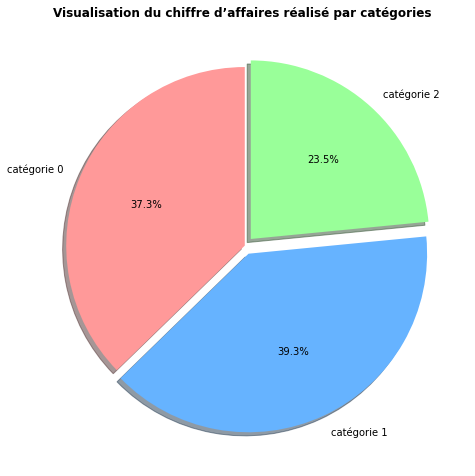

In [52]:
fig = plt.figure(figsize= [8,12])
labels = 'catégorie 0','catégorie 1','catégorie 2'

sizes=[CA_categ[0], 
       CA_categ[1],
       CA_categ[2]] 

explode = (0,0.05,0.05)  
ax = fig.add_subplot()

#add colors
colors = ['#ff9999','#66b3ff','#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Visualisation du chiffre d’affaires réalisé par catégories ',fontweight="bold")
plt.show()

In [32]:
#Calcul du nombre de ventes
Nb_vente_total = df["price"].count()

#Affichage nombre de ventes total avec la fonction print()
print(f'Le nombre total de ventes réalisé est de : {round(Nb_vente_total ,2)} articles')

Le nombre total de ventes réalisé est de : 679111 articles


In [55]:
#Affichage nombre de ventes par catégorie avec la fonction groupby()
Nb_vente_categ=df.groupby('categ')['price'].count()

#Affichage nb ventes par categorie avec la fonction print()
print(f'Le nombre total de ventes réalisés par la catégorie 0 est de : {round(Nb_vente_categ[0],2)} euros')
print(f'Le nombre total de ventes réalisés par la catégorie 1 est de : {round(Nb_vente_categ[1],2)} euros')
print(f'Le nombre total de ventes réalisés par la catégorie 2 est de : {round(Nb_vente_categ[2],2)} euros')

Le nombre total de ventes réalisés par la catégorie 0 est de : 415459 euros
Le nombre total de ventes réalisés par la catégorie 1 est de : 227169 euros
Le nombre total de ventes réalisés par la catégorie 2 est de : 36483 euros


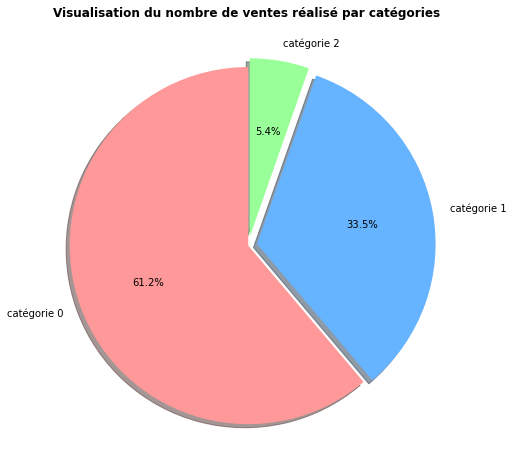

In [57]:
fig = plt.figure(figsize= [8,12])
labels = 'catégorie 0','catégorie 1','catégorie 2'

sizes=[Nb_vente_categ[0], 
       Nb_vente_categ[1],
       Nb_vente_categ[2]] 

explode = (0,0.05,0.05)  
ax = fig.add_subplot()

#add colors
colors = ['#ff9999','#66b3ff','#99ff99']

ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)

ax.set_title('Visualisation du nombre de ventes réalisé par catégories ',fontweight="bold")
plt.show()

## Analyser l’évolution dans le temps et mettre en place une décomposition en moyenne mobile pour évaluer la tendance globale

<AxesSubplot:xlabel='ANNEE', ylabel='count'>

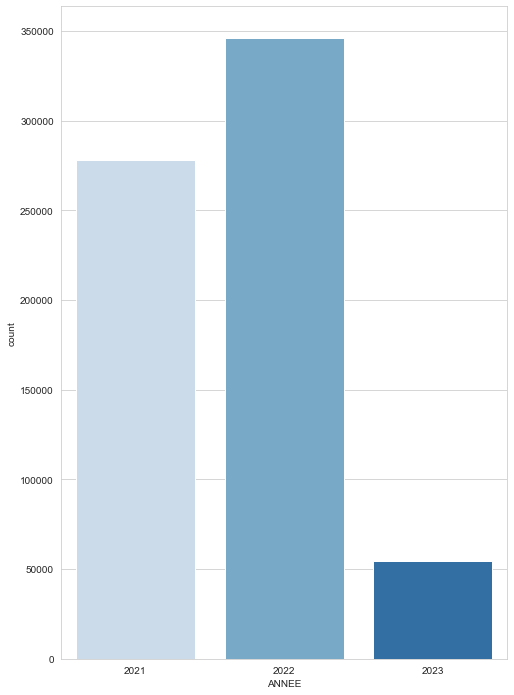

In [99]:
fig = plt.figure(figsize= [8,12])
sns.set_style('whitegrid')
sns.countplot(x='ANNEE', data=df, palette='Blues')

In [94]:
TDA =pd.pivot_table(df, index=['Date'],values=['price','ANNEE'], aggfunc={'price': np.sum})

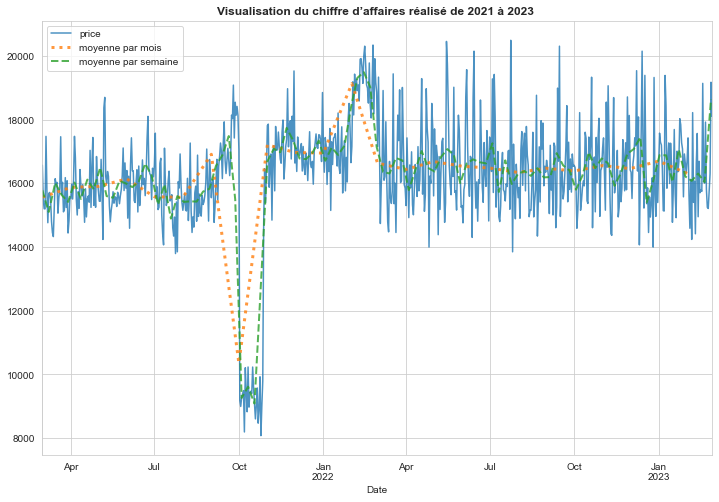

In [116]:
plt.figure(figsize=(12,8))
TDA.loc['2021':'2023']['price'].plot(alpha=0.8)
TDA.loc['2021':'2023']['price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TDA.loc['2021':'2023']['price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()

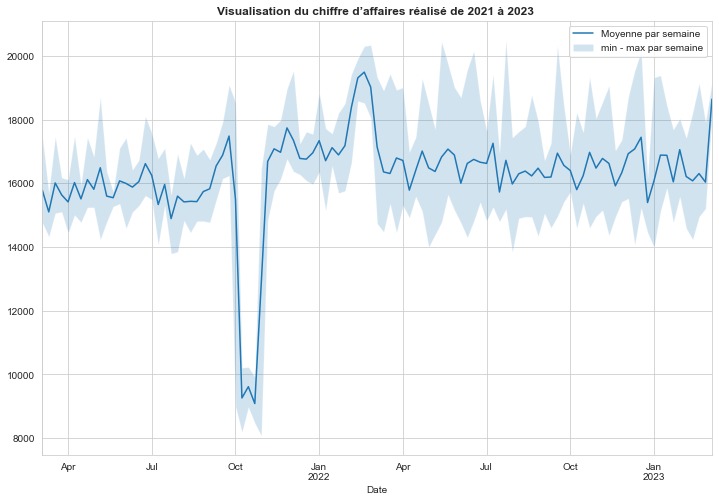

In [115]:
m=TDA['2021':'2023']['price'].resample('W').agg(['mean','min','max'])

plt.figure(figsize=(12,8))
m['mean']['2021':'2023'].plot(label='Moyenne par semaine')
plt.fill_between(m.index,m['max'],m['min'],alpha=0.2, label='min - max par semaine')
plt.title('Visualisation du chiffre d’affaires réalisé de 2021 à 2023 ',fontweight="bold")
plt.legend()
plt.show()


## Faire un zoom sur les références, pour voir un peu les tops et les flops, 

## la répartition par catégorie, etc. Enfin, j’aimerais avoir quelques informations sur les profils de nos clients, et également la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.

## Le lien entre le genre d’un client et les catégories des livres achetés

In [80]:
TDC =pd.pivot_table(df, index=['categ'], columns=['sex'],values=['age','price'], aggfunc={'age' :np.mean, 'price': np.mean})

In [81]:
TDC

age                 price           
sex            f          m          f          m
categ                                            
0      44.257381  43.543104  10.625818  10.650365
1      48.362318  46.923506  20.526001  20.444515
2      26.571255  25.387031  75.869527  76.511561

On peut observer que :
* La catégorie 0 à en moyenne le plus petit  panier moyen (10eur) avec une moyenne d'age femme/homme entre 44 et 43 ans
* La catégorie 1 à un panier moyen à 20eur avec une moyenne d'age la plus elevée femme/homme entre 48 et 46 ans
* la catégorie 2 à un panier moyen le plus elevé à 75eur avec une moyenne d'age  femme/homme entre 26 et 25 ans

<AxesSubplot:xlabel='categ', ylabel='count'>

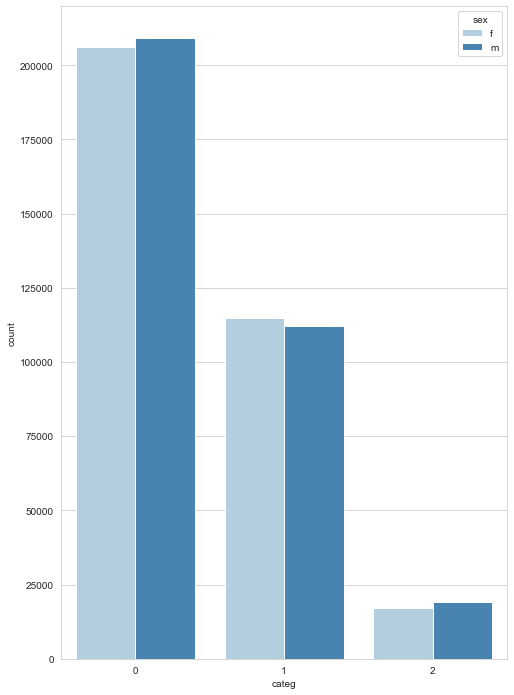

In [72]:
fig = plt.figure(figsize= [8,12])
sns.set_style('whitegrid')
sns.countplot(x='categ', hue='sex', data=df, palette='Blues')

## Le lien entre l’âge des clients et le montant total des achats

<AxesSubplot:xlabel='age', ylabel='count'>

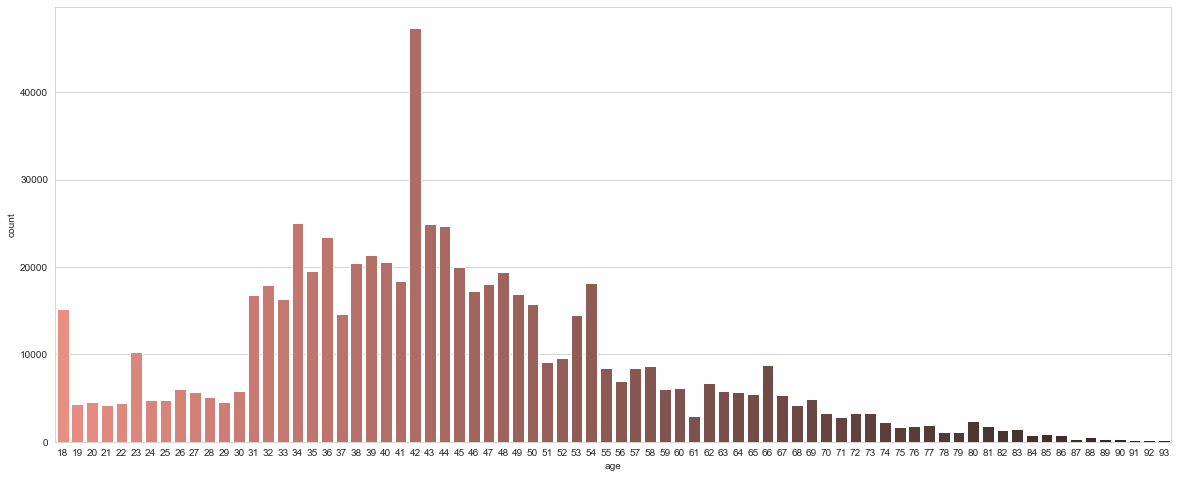

In [90]:
fig = plt.figure(figsize= [20,8])
sns.set_style('whitegrid')
sns.countplot(x='age', data=df, palette='dark:salmon_r')

<AxesSubplot:xlabel='categ', ylabel='age'>

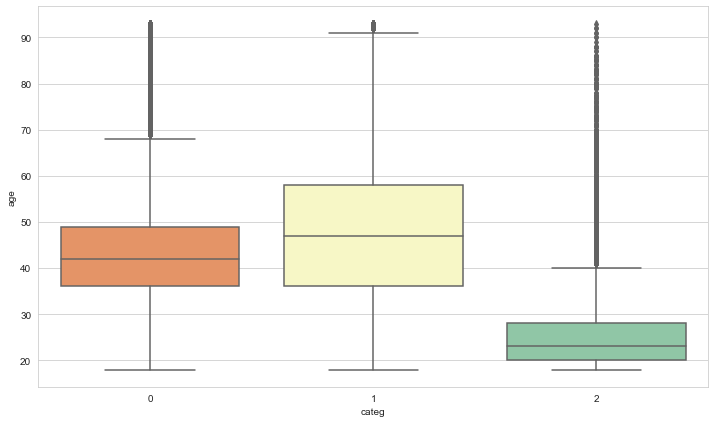

In [71]:
plt.figure(figsize=(12,7))
sns.boxplot(x='categ', y= 'age', data=df, palette="Spectral" )

# Imputation

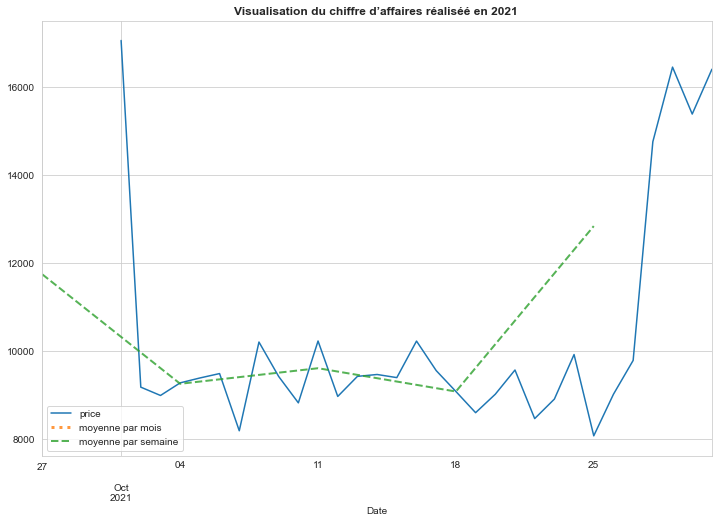

In [105]:
plt.figure(figsize=(12,8))
TDA.loc['2021-10','price'].plot()
TDA.loc['2021-10','price'].resample('M').mean().plot(label='moyenne par mois',lw=3, ls=':', alpha=0.8)
TDA.loc['2021-10','price'].resample('W').mean().plot(label='moyenne par semaine',lw=2, ls='--', alpha=0.8)
plt.title('Visualisation du chiffre d’affaires réaliséé en 2021 ',fontweight="bold")
plt.legend()
plt.show()

# Building a Regression model